TedEx Talks Dataset Topic Modeling and Analysis:
---
TedEx Data is being downloaded from Kaggle which contains the information about 2467 ted talks arranged between 2007 and 2014. The dataset contains complete "Transcript" of the talk, "Number of Comments" it grossed on the discussion forums, "Number of Views", and the information about the Author and Topic of each talk.

Task 1:
Motivation for this project is to find the general topics (Genres) for different type of talks such that we can cluster 2467 talks in a few topics, e.g if we have 6 talks where the theme was "Personal Growth and Motivation", all of them should be clustered in the topic "Personal Growth and Motivation". This is an unsupervised problem where we have the transcript for 2467 talks and we have to generate let's say 10-15 topics that represent all these 2467 talks. 

Task 2:
With the topics identified it would be interesting to know that what kind of topics gross most comments on discussion forums and what kind of talk gets viewed the most. Also, we are given the date the Talk was arranged, so we can also learn how the trend in the popularity of each topic has changed over the years. e.g maybe in 2007 talks related to "Science and Innovation" were famous while in 2016 the talks related to "Politics and Economic Issues" were famous.


In [5]:
import numpy as np
import os
import pandas as pd
import csv
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

Loading the Data:
---

In [3]:
# TedEx data loading:
path="/Users/Muhammad Hussain/Desktop/Data_Science_Datasets"

# Loading the Transcripts of each TedEx talks:
transcript=pd.read_csv(os.path.join(path,"transcripts.csv"))


# Loading Data regarding each TedEx Talk:
datu=pd.read_csv(os.path.join(path,"ted_main.csv"))
# Some preprocessing by dropping a few columns:
datu=datu.drop(columns=["event","film_date","name","num_speaker","ratings","related_talks"])

# Merging two dataframes on the basis of url:
datu=datu.merge(transcript,left_on=["url"],right_on=["url"],how="inner")
transcript["views"],transcript["comments"]=datu["views"],datu["comments"]

# Preprocessing on "Published Date" column and creating 3 separate columns of Year, Month and Day:
from datetime import datetime
dates=[(lambda x: str(datetime.fromtimestamp(x))) (x) for x in datu.published_date]
p=pd.DataFrame(dates,columns=["date"])
datu["published_date"]=dates
datu["published_date"]=pd.to_datetime(datu["published_date"],format='%Y-%m-%d %H:%M:%S')
days=[i.day for i in datu["published_date"]]
month=[i.month for i in datu["published_date"]]
year=[i.year for i in datu["published_date"]]
datu["year"]=year
datu["month"]=month
datu["day"]=days
datu.published_date=datu["published_date"].apply(lambda x: x.strftime('%Y-%m-%d'))

Descriptive Statistics:
---

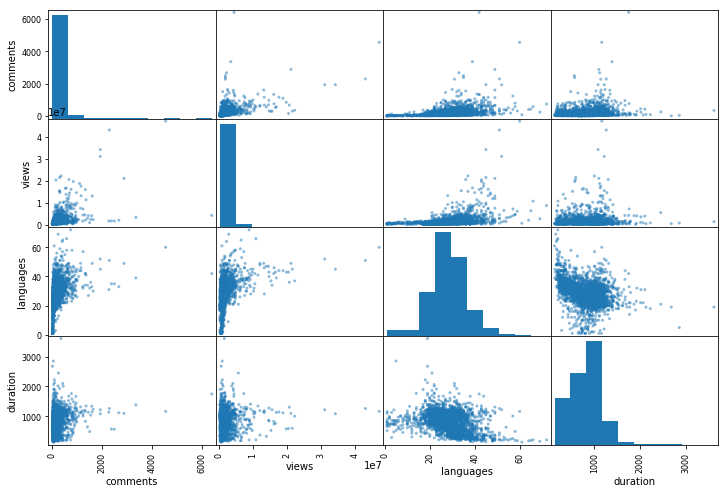

       comments        views  languages  duration
count   2467.00      2467.00    2467.00   2467.00
mean     192.57   1740295.44      28.29    821.76
std      284.83   2527086.23       8.23    334.09
min        2.00    155895.00       1.00    135.00
25%       63.00    787578.50      23.00    582.00
50%      117.00   1149090.00      28.00    852.00
75%      222.50   1736256.00      33.00   1047.00
max     6404.00  47227110.00      72.00   3608.00


In [4]:
# Lets do a scatter matrix and then see what kind of features we have:
pd.plotting.scatter_matrix(datu[["comments","views","languages","duration"]],figsize=(12,8))
plt.show()

# pd.scatter_matrix(df, figsize=(6, 6))

# Some Descriptive stats of the data:
num_data=datu[["comments","views","languages","duration"]]
desc=num_data.describe()
print(desc.round(2))


By looking at the data description, comments are strongly skewed to the right, with about 75% of the Ted Talks gathering less than 222 comments, same goes for the views as well. High Standard deviation proves that the variability in comments is pretty high. Which might be becasue of the type of talk, the year it was arranged in or due to the writer's profile. we'll explore all these facts in the later sections.

-----------
Topic Modeling:
-------------
On of the main tasks for this project is to see what kind of talk gathers most comments and views so that we can decipher how the trend has shifted from 2007 to 2017 w.r.t the popularity of topics. To do that we need to perform topic modeling on our corpus of 2467 talks. To do that first we need to find a way to cluster the similar kind of talks together in one cluster and once we have decided on how many clusters can represent our 2467 talks, we can start clustering the talks and each cluster can serve as a Topic.

Steps:

1. First generate the vector representations of each talk using the transcript data of that talk. I have used Doc2Vec Model from Python Gensim Library to generate vector representation of each talk.
2. After generating vectors, i used Spherical Clustering to cluster similar documents together in same cluster. I wanted to used Cosine Similarity as a measure for clustering, for the reason i have used Spherical Clustering.
3. Number of Clusters have been decided by doing elbow-joint analysis using cluster-distortion as the decision metric.
4. Once documents have been clustered i would use top 10 most common words used in the documents falling in one cluster as the topic for that cluster.

In [6]:
# Using Doc2Vec to create document's vector representations

from stop_words import get_stop_words
stop_words = get_stop_words('en')
stopu=set(stop_words)

import nltk
nltk.download('punkt')
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize

documents=list(datu.transcript)

tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(documents)]


[nltk_data] Error loading punkt: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
C:\Users\Muhammad Hussain\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [30]:
lengths=[len(tagged_data[i][0]) for i in np.arange(0,len(tagged_data))]

# Applying Doc2Vec to learn vector representations of each of the document:

np.average(lengths)
max_epochs = 70
vec_size = 70
alpha = 0.02

model = Doc2Vec(size=vec_size,
                alpha=alpha, 
                min_alpha=0.00025,
                min_count=3,
                dm =1)
  
model.build_vocab(tagged_data)

for epoch in range(max_epochs):
    print('iteration {0}'.format(epoch))
    model.train(tagged_data,
                total_examples=model.corpus_count,
                epochs=model.iter)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha

model.save("d2v3.model")
print("Model Saved")



iteration 0


C:\Users\Muhammad Hussain\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19
iteration 20
iteration 21
iteration 22
iteration 23
iteration 24
iteration 25
iteration 26
iteration 27
iteration 28
iteration 29
iteration 30
iteration 31
iteration 32
iteration 33
iteration 34
iteration 35
iteration 36
iteration 37
iteration 38
iteration 39
iteration 40
iteration 41
iteration 42
iteration 43
iteration 44
iteration 45
iteration 46
iteration 47
iteration 48
iteration 49
iteration 50
iteration 51
iteration 52
iteration 53
iteration 54
iteration 55
iteration 56
iteration 57
iteration 58
iteration 59
iteration 60
iteration 61
iteration 62
iteration 63
iteration 64
iteration 65
iteration 66
iteration 67
iteration 68
iteration 69


C:\Users\Muhammad Hussain\Anaconda3\lib\site-packages\smart_open\smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Model Saved


In [7]:
# Loading the saved model:
model3=Doc2Vec.load("d2v3.model")

C:\Users\Muhammad Hussain\Anaconda3\lib\site-packages\smart_open\smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [8]:
# Clustering the Document Vectors:
# Doing SPherical Clustering with Cosine Similarity as the Distance measure:
import numpy as np
doc_vecs=model3.docvecs
l=[]
from sklearn.metrics import silhouette_samples, silhouette_score
from spherecluster import SphericalKMeans

for i in np.arange(0,len(doc_vecs)):
    l.append(doc_vecs[i])
vecs=np.array(l)
vecs.shape


distortion_spherical=[]

for i in [4,5,6,7,8,9,10,11,12,13]:
    skm=SphericalKMeans(n_clusters=i)
    skm.fit(vecs)
    cluster_labels=skm.labels_
    distortion=skm.inertia_
    distortion_spherical.append(distortion)

Elbow-Joint Analysis:
---
Below is the plot for CLuster Distortions for different number of clusters chosen. The plot shows that cluster distortion is lowest when number of clusters are 13, which was actually expected. But as we see that the reduction in cluster distortions is pretty low as the number of cluster increases after 10. So, the choice could be 10 or 11 number of clusters. I went with 11 clusters.


Text(0.5, 1.0, 'Spherical Clustering')

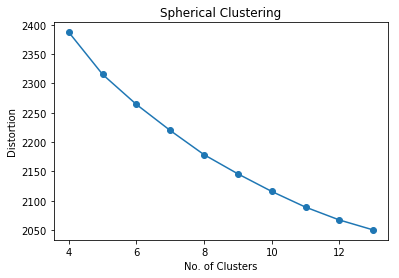

In [9]:
# Clustering Visualizations:

import matplotlib.pyplot as plt
clusters=[4,5,6,7,8,9,10,11,12,13]

plt.figure()
plt.plot(clusters,distortion_spherical,"o-")
plt.xlabel("No. of Clusters")
plt.ylabel("Distortion")
plt.title("Spherical Clustering")

In [12]:
# Choosing num_clusters=11
from spherecluster import SphericalKMeans
n_clustu=11
skm=SphericalKMeans(n_clusters=n_clustu)
skm.fit(vecs)
cluster_labels=skm.labels_
datu["Cluster_labels"]=cluster_labels


Using TSNE to visualize the talks vectors in 2-dimensions with their labeled cluster assignment:
---

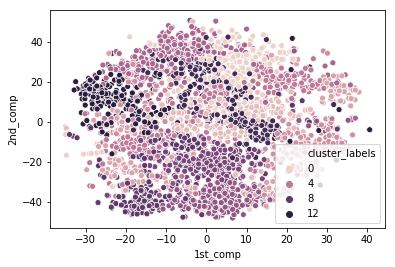

In [11]:
# Spherical Clustering using vectors generated by model 3:

from spherecluster import SphericalKMeans
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA

from sklearn.manifold import TSNE

# vecs_1=model.docvecs
# vecs_2=model2.docvecs

vecs_3=model3.docvecs

# def tsne_visualizations:

def tsne_visualization_data(vecs_doc):
    l=[]
    for i in np.arange(0,len(vecs_doc)):
        l.append(vecs_doc[i])
    vecs=np.array(l)
    skm=SphericalKMeans(n_clusters=11)
    skm.fit(vecs)
    cluster_labels=skm.labels_
    pca=PCA(n_components=10)
    vecs_pca=pca.fit_transform(vecs)
    fashion_tsne = TSNE(learning_rate=800,n_components=2,perplexity=50).fit_transform(vecs_pca)
    plot_data=pd.DataFrame(fashion_tsne)
    plot_data["cluster_labels"]=cluster_labels
    plot_data.columns=["1st_comp","2nd_comp","cluster_labels"]
    return plot_data
    

datu_tsne=tsne_visualization_data(vecs_3)
sns.scatterplot(x="1st_comp",y="2nd_comp",hue="cluster_labels",data=datu_tsne)

Topic Generation:
---
Generating Topics for each cluster using "Tags: Most frequently used words in the documents falling in that cluster". So, each document(Talk) has tags: Most frequently used words excluding the Stop Words, i am combining tags from all the documents falling in one cluster together and then taking top 15 used words to generate a topic for each cluster.

In [14]:
datu_new=datu.loc[:,["comments","views","Cluster_labels","tags","title"]]
# datu_new.loc[datu_new["Cluster_labels"]==1,]

# Analysis:
# Making the cluster topics using tags:
num_words_topics=15

import numpy as np
import ast
topics=[]
for i in range(n_clustu):
    nm=datu_new.loc[datu_new["Cluster_labels"]==i,].tags
    l=list(pd.DataFrame(nm).reset_index().tags)
    az=[]
    for j in np.arange(0,len(l)):
        s=""
        x=s+l[j].strip('][')
        az.append([i for i in ast.literal_eval(x)])
    flat_list = [item for sublist in az for item in sublist]
    v=pd.DataFrame(pd.Series(flat_list).value_counts().sort_values(ascending=False)[:15]).reset_index().iloc[:,0].values
    topics.append(", ".join([i for i in v]))

print(topics)

['design, technology, cities, business, global issues, environment, architecture, green, TEDx, sustainability, infrastructure, innovation, culture, invention, science', 'culture, entertainment, performance, music, storytelling, humanity, personal growth, poetry, global issues, live music, TEDx, communication, society, art, religion', 'technology, design, computers, science, entertainment, brain, creativity, TEDx, art, robots, invention, education, innovation, demo, AI', 'technology, business, global issues, culture, TEDx, Internet, communication, society, government, data, politics, computers, social media, economics, collaboration', 'science, biology, environment, animals, nature, oceans, technology, biodiversity, ecology, global issues, TEDx, exploration, climate change, life, evolution', 'science, technology, physics, universe, astronomy, space, exploration, future, TEDx, history, innovation, biology, Planets, math, life', 'global issues, business, economics, global development, pol

Some of the words like "culture" are used in many topics so, i have trimmed the topics a bit by choosing those words that are not being used in more than 5 topics. I have trimmed the topics so that they are more distinct. Let's visualize the trimmed topics.
---

In [16]:
# Trimming the topics a bit:
# Making a dictionary of topic words:
v=""
for i in np.arange(0,len(topics)):
    x=topics[i]
    v=v+x

bow=v.split(", ")


k=pd.Series(bow).value_counts()
k=k.reset_index()
k.columns=["words","count"]
choosen_words=list(k.loc[k["count"]<=4,"words"])

new_topics=[]
for i in topics:
    l=i.split(", ")
    new_topic=[]
    for j in l:
        if j in choosen_words:
            new_topic.append(j)
    new_topics.append(new_topic)

new_topicsu=[', '.join(i) for i in new_topics]

trimmed_topics=pd.DataFrame(new_topicsu,np.arange(0,n_clustu)).reset_index()
trimmed_topics.columns=["Cluster_labels","Trimmed_Topics"]
analysis_dataset=datu.merge(trimmed_topics,left_on="Cluster_labels",right_on="Cluster_labels",how="inner")
analysis_dataset=analysis_dataset.drop(columns=["description","tags","url","transcript"])
analysis_dataset.drop_duplicates(inplace=True)
trimmed_topics.Trimmed_Topics

0     design, cities, business, global issues, envir...
1     entertainment, performance, music, storytellin...
2     design, computers, science, entertainment, bra...
3     business, global issues, Internet, communicati...
4     science, biology, environment, animals, nature...
5     science, physics, universe, astronomy, space, ...
6     global issues, business, economics, global dev...
7     science, health, medicine, health care, medica...
8     global issues, social change, women, activism,...
9     design, art, entertainment, creativity, music,...
10    business, psychology, social change, personal ...
Name: Trimmed_Topics, dtype: object

Trend Analysis:
---

Famous Topics for Discussion Forums, i.e the topics Grossing Most Comments:
--------------------------
1. The Topics that includes 1. Pscycology, Cognitive Science and nueroscience has grossed the most comments, topping the list, followed by Social Change, Personal Growth and Children's Development. On third we have got topic that includes Global Economic Issues and Development, and Climate Change.
2. The two lowest comments grossing topics are about Medical Research, biotech and cancer research development, followed by city Infrastructure and architecture.

In [15]:
# First let's see which topics have averagingly more comments along with the number of talks arranged over the years from 2006-2017:

summary_1=analysis_dataset.groupby(["Trimmed_Topics"])["comments"].agg({"num_talks":"count",
                                                                        "avg_comments":"mean"}).round(2).sort_values("avg_comments",ascending=False).reset_index()
summary_1_1=summary_1.merge(analysis_dataset[["Trimmed_Topics","Cluster_labels"]].drop_duplicates(),on=["Trimmed_Topics"],how="left")
# summary_1_1.sort_values([""])
# print(summary_1_1[["Trimmed_Topics","avg_comments"]])
analysis_dataset.groupby(["Trimmed_Topics"])["comments"].agg({"num_talks":"count",
                                                                        "avg_comments":"mean"}).round(2).sort_values("avg_comments",ascending=False)

C:\Users\Muhammad Hussain\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
C:\Users\Muhammad Hussain\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


,num_talks,avg_comments
Trimmed_Topics,,
"psychology, science, brain, philosophy, neuroscience, society, happiness, mind, cognitive science, communication, humanity",186,354.92
"education, society, personal growth, social change, motivation, children, work, psychology, women, identity",186,252.99
"economics, global development, politics, Africa, social change, science, government, future, environment, climate change",214,248.52
"science, physics, future, universe, space, astronomy, exploration, design, innovation, invention, engineering, computers, biology",224,201.00
"entertainment, storytelling, performance, music, art, personal growth, humanity, communication, live music, poetry, creativity, society",242,196.04
"social change, women, activism, war, society, politics, art, community, entertainment, identity, violence, humanity",292,177.01
"Internet, communication, data, government, collaboration, politics, computers, social media, society",219,166.04
"science, biology, environment, animals, nature, oceans, biodiversity, ecology, exploration, evolution, climate change",214,150.01
"science, health, medicine, health care, medical research, innovation, biology, disease, biotech, design, invention, illness, cancer",225,140.87


Year-Wise Distribution of Average Comments for all talks: 
-------
The summary below gives the average number of commetns grossed by talks over the years from 2007 to 2017.



      countsu  avg_comments
year                       
2006       50    363.420000
2007      119    208.361345
2008      185    147.659459
2009      215    200.153488
2010      233    323.296137
2011      247    246.991903
2012      276    218.902174
2013      241    290.024896
2014      240    158.691667
2015      220    118.031818
2016      243     81.308642
2017      195     50.523077


C:\Users\Muhammad Hussain\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.


Text(0.5, 1.0, 'Trend of Avg Comments grossed by each talk over the years')

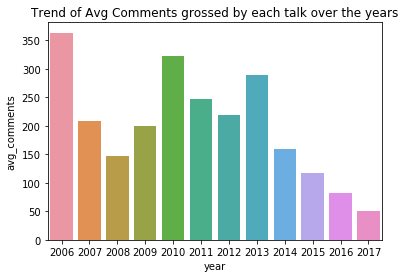

In [18]:
summary_2=analysis_dataset.groupby(["year"])["comments"].agg({"countsu":"count","avg_comments":"mean"})
print(summary_2)
sns.barplot(x="year",y="avg_comments",data=summary_2.reset_index())
plt.title("Trend of Avg Comments grossed by each talk over the years")

- The summary above indicates that in year 2016 and 2017, talks from each topic has the lowest average comments. Maybe people got less inclined to discuss TedTalks on forums as the years passed, or maybe they lost interest in the Ted Talks.
- This can be confirmed by looking at the Distribution of Average Comments grouped by Topics w.r.t years, and see if each topic has lowest comments grossing talks in the years 2016 and 2017.

Let's find out.

Findings about the Discussion Trends over the years:
-------------------------------
The summary of Avg_Comments grouped by topics from w.r.t years confirms my intuition about each talk grossing the least amount of comments in the last 3 years of 2015, 2016 and 2017. Here in the above visualization we can see the decline in the Average Comments starting from 2014 to 2017 where we have the least number of average comments on any talk. This is an indication that maybe people are less inclined on discussing the Ted Talks in years 2014 and after than they used to be before 2014.


In [17]:
# Now lets look at the topics and their year wise distribution, this way we can track the trend of each topic popularity over the years.
# Surprisingly all the topics have got least amount of comments in the last 3 years of 2015,2016 and 2017.
summary_1=analysis_dataset.groupby(["Trimmed_Topics","year"])["comments"].agg({"talks_num":"count",
                                                                   "avg_comments":"mean"}).sort_values(["Trimmed_Topics","avg_comments"],
                                                                                                      ascending=[True,False])
summary_1

C:\Users\Muhammad Hussain\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.


talks_num  \
Trimmed_Topics                                     year              
business, global issues, Internet, communicatio... 2010         20   
                                                   2011         17   
                                                   2013         18   
                                                   2012         34   
                                                   2009         17   
                                                   2014         28   
                                                   2007          7   
                                                   2008         11   
                                                   2015         17   
                                                   2016         19   
                                                   2006          3   
                                                   2017         25   
business, psychology, social change, personal g... 2006          8   
                                                   2010         24   
                                                   2013         27   
                                                   2012         27   
                                                   2009         16   
                                                   2008         11   
                                                   2011         25   
                                                   2015         29   
                                                   2014         25   
                                                   2007          4   
                                                   2016         35   
                                                   2017         26   
design, art, entertainment, creativity, music, ... 2011         19   
                                                   2006          7   
                                                   2013         18   
                                                   2010         20   
                                                   2009         35   
                                                   2007         11   
...                                                            ...   
science, biology, environment, animals, nature,... 2012         20   
                                                   2007         13   
                                                   2014         19   
                                                   2015         16   
                                                   2016         19   
                                                   2017         12   
science, health, medicine, health care, medical... 2007          2   
                                                   2006          6   
                                                   2013         22   
                                                   2011         30   
                                                   2009         16   
                                                   2010         26   
                                                   2012         30   
                                                   2014         27   
                                                   2015         23   
                                                   2008          8   
                                                   2016         23   
                                                   2017         19   
science, physics, universe, astronomy, space, e... 2007         18   
                                                   2013          9   
                                                   2014         15   
                                                   2006          4   
                                                   2012         17   
                                                   2011         20   
                                                   2010         12 

Most Comments Grossing Topics every year:
----------------
- Although the trend in discussions over Ted Talks have faded over the years =, but it would still be useful to look at all the most discussed topic every year and how it changed from 2006 to 2017.
- Below is a summary that gives us an idea about how the popularity of topics changed over the years, e.g from 2006 to 2010, Topics like "Pscycology, Philosophy, Neuroscience and Cognitive Development" and "Entertainment, Music, Art and Creativity" are the two most popular topics interchangeably over the years.
- From 2012 and 2013 the talks related to the topic of "Social Change, Personal Growth and Motivation" have been the most comments grossing topics.
- Then in 2016 and 2017 the topic of "Global Issues, Economics and Politics" have been grossing the most comments.
- Thus it seems like in 2016 and 2017 people are more interested to talk about Political and Global issues.

In [196]:
# Let's check the most popular type of talks every year and how they chnaged:

kk=analysis_dataset.groupby(["year","Trimmed_Topics"])["comments"].agg({"avg_comments":"mean"}).reset_index()
kk2=kk.groupby(["year"])["avg_comments"].max().reset_index()
kk3=kk2.merge(kk,on=["avg_comments","year"],how="inner")


C:\Users\Muhammad Hussain\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


,year,avg_comments,Trimmed_Topics
0,2006,1143.285714,"science, brain, psychology, neuroscience, phil..."
1,2007,669.933333,"science, brain, psychology, neuroscience, phil..."
2,2008,252.250000,"entertainment, music, performance, art, creati..."
3,2009,297.000000,"science, brain, psychology, neuroscience, phil..."
4,2010,655.250000,"science, brain, psychology, neuroscience, phil..."
5,2011,461.000000,"entertainment, music, performance, art, creati..."
6,2012,442.240000,"social change, women, personal growth, childre..."
7,2013,515.083333,"social change, women, personal growth, childre..."
8,2014,331.000000,"science, physics, space, universe, exploration..."
9,2015,241.777778,"science, brain, psychology, neuroscience, phil..."


Pairwise T-Test:
---
To find what's going on in the years >2014, i have a proposition. First we need to see if there is any difference for Avg_Number of Comments grossed by talk of some specific topic between the years <=2014 and >2014.
Becasue if there is a difference statistically, then it means that that topic has lost or gained some popularity in that specific era.
Let me explain this using an example. Let's consider all the talks on the topic of Global Issues and Climate Change, and see the average number of comments grossed for all the talks in the category that happend before or in 2014, and after 2014. And if the avg_num_comments are higher for <2014 time and lower for >2014, then it means that talk has lost its popularity over time.

In [254]:
dataset=analysis_dataset[["Cluster_labels","year","comments"]]
dataset=dataset.loc[dataset["year"]>=2010,:]
year_cat=[]
for i in dataset["year"]:
    if i<=2014:
        year_cat.append("<=2014")
    else:
        year_cat.append(">=2015")
dataset["year_category"]=year_cat


import numpy as np
from scipy import stats
i=1

t_stats=[]
p_vals=[]
result=[]
for i in np.arange(0,11):
    dats=dataset.loc[dataset["Cluster_labels"]==i,]
    random_sample=np.random.choice(len(dats),150)
    x_1=x.loc[x["year_category"]=="<=2014","comments"]
    x_2=x.loc[x["year_category"]==">=2015","comments"]
    
    random_sampling=np.random.choice(min(len(x_1),len(x_2)),replace=True,size=120)
    
    x_1=np.array(x_1.iloc[random_sampling,])
    x_2=np.array(x_2.iloc[random_sampling,])
    t2, p2 = stats.ttest_ind(x_1,x_2)
    t_stats.append(t2)
    if p2<=0.05:
        result.append("Reject_H0")
    else:
        result.append("Fail to Reject H0")
    p_vals.append(p2)

Cluster_labels=np.arange(0,11)
data_summary=pd.DataFrame(Cluster_labels)
data_summary["T_Statistic"]=np.array(t_stats).round(2)
data_summary["Result"]=result
data_summary.columns=["Cluster_labels","T_statistic","Result"]
data_summary

,Cluster_labels,T_statistic,Result
0,0,5.06,Reject_H0
1,1,5.19,Reject_H0
2,2,5.17,Reject_H0
3,3,4.80,Reject_H0
4,4,5.75,Reject_H0
5,5,5.49,Reject_H0
6,6,4.11,Reject_H0
7,7,5.58,Reject_H0
8,8,5.63,Reject_H0
9,9,5.16,Reject_H0


Findings:
---
- For all the Topic_Labels i ran T-Test to see if there is any significant difference between average comments grossed in talks happened before 2014 and after it. Separate T-Tests on talks from all categories(Topics) indicate that in the years 2015 and onwards average comments have declined as a whole and are independent of the type of talk.
- I feel that the over the years people has lost interests indiscussing the talks or writing comments on them, the above experiment is the proof that no matter what the topic of a talk is, after 2015 if you arranged a talk on any type of topic, it would not gross as many comments as it would have if the same talk was arranged before 2015.

In [260]:
top_speakers=[i for i in analysis_dataset.sort_values("comments",ascending=False).iloc[:15,3]]
analysis_dataset.loc[analysis_dataset["main_speaker"].isin(top_speakers),["comments","main_speaker","year","title","Cluster_labels"]].sort_values(["main_speaker","year"],ascending=True)

,comments,main_speaker,year,title,Cluster_labels
2378,1586,Allan Savory,2013,How to fight desertification and reverse clima...,2
931,2290,Amy Cuddy,2012,Your body language may shape who you are,9
886,1927,Brené Brown,2010,The power of vulnerability,9
916,707,Brené Brown,2012,Listening to shame,9
1761,2673,David Chalmers,2014,How do you explain consciousness?,1
2061,1604,Elizabeth Gilbert,2009,Your elusive creative genius,6
2175,183,Elizabeth Gilbert,2014,"Success, failure and the drive to keep creating",6
759,1640,Eric X. Li,2013,A tale of two political systems,10
67,1545,James Randi,2010,"Homeopathy, quackery and fraud",3
2101,2492,Janet Echelman,2011,Taking imagination seriously,6


Analysis on Views:
---

C:\Users\Muhammad Hussain\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


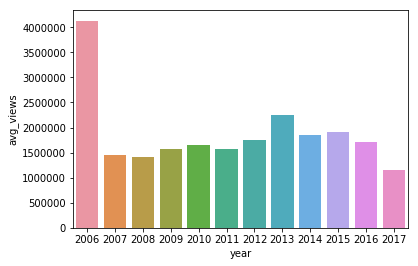

In [24]:
# Analysis on Views:

views_analysis=analysis_dataset.groupby("year")["views"].agg({"avg_views":"mean"}).reset_index()
sns.barplot(x="year",y="avg_views",data=views_analysis)
# kk_views=analysis_dataset.groupby(["year","Trimmed_Topics"])["views"].agg({"avg_views":"mean"}).reset_index()
# kk2_views=kk_views.groupby(["year"])["avg_views"].max().reset_index()
# kk3_views=kk2_views.merge(kk_views,on=["avg_views","year"],how="inner")
# kk3_views

Pattern of the Average Number of Views gathered by Different Talks over the years have been fairly the same, by saying "Fairly the same", i mean that the number of views did not decline with the years, as did the comments. Thus, it means we can decipher how the popularity of a talk changed over the years w.r.t the views it grossed.

Let's dive a bit into the Views and see if some pattern emerges.

I'd first look at the basic summary of which type of talks are most viewed and which are least viewed.


In [27]:
summary=analysis_dataset.groupby("Trimmed_Topics")["views"].agg({"avg_views":"mean"}).round(2).sort_values("avg_views",ascending=False)
summary

C:\Users\Muhammad Hussain\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.


,avg_views
Trimmed_Topics,
"education, society, personal growth, social change, motivation, children, work, psychology, women, identity",3450962.73
"psychology, science, brain, philosophy, neuroscience, society, happiness, mind, cognitive science, communication, humanity",3032090.09
"entertainment, storytelling, performance, music, art, personal growth, humanity, communication, live music, poetry, creativity, society",1827877.93
"design, entertainment, art, creativity, music, computers, humor, performance, invention, science, collaboration",1797224.45
"science, physics, future, universe, space, astronomy, exploration, design, innovation, invention, engineering, computers, biology",1645997.76
"Internet, communication, data, government, collaboration, politics, computers, social media, society",1544697.55
"social change, women, activism, war, society, politics, art, community, entertainment, identity, violence, humanity",1328733.05
"economics, global development, politics, Africa, social change, science, government, future, environment, climate change",1307269.58
"science, biology, environment, animals, nature, oceans, biodiversity, ecology, exploration, evolution, climate change",1257630.81


Above summary shows the type of topics and the average number views of any talk of that respective topic.
---
1. The topic of "Education, Social Change, Motivation and Personal Growth" tops the list with the "Psycology" followed by the topic "Pscycology, Cognitive Science and Nueroscience", as on average talks from these two topics gross the most views.
2. The talks belonging to the topics "Design and Infrastructure of Cities" and "Medical Research and Innovation" has grossed the least number of views.

Notice that this result is the same as we got for Avg Number of Comments grossed by talk of different topics.

Year-Wise most popular topic in terms of Views:
---
Now Let's see which topic has been most popular in terms of grossing highest number of reviews each year, this can give us an idea of how the trend has changed over the years.

In [28]:
kk_views=analysis_dataset.groupby(["year","Trimmed_Topics"])["views"].agg({"avg_views":"mean"}).reset_index()
kk2_views=kk_views.groupby(["year"])["avg_views"].max().reset_index()
kk3_views=kk2_views.merge(kk_views,on=["avg_views","year"],how="inner")
kk3_views

C:\Users\Muhammad Hussain\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.


,year,avg_views,Trimmed_Topics
0,2006,1.384244e+07,"education, society, personal growth, social ch..."
1,2007,2.829234e+06,"psychology, science, brain, philosophy, neuros..."
2,2008,2.565913e+06,"psychology, science, brain, philosophy, neuros..."
3,2009,3.680294e+06,"psychology, science, brain, philosophy, neuros..."
4,2010,5.268961e+06,"education, society, personal growth, social ch..."
5,2011,3.016886e+06,"education, society, personal growth, social ch..."
6,2012,5.730441e+06,"education, society, personal growth, social ch..."
7,2013,5.842207e+06,"education, society, personal growth, social ch..."
8,2014,3.406992e+06,"education, society, personal growth, social ch..."
9,2015,3.767827e+06,"psychology, science, brain, philosophy, neuros..."


The topic of "Education, Social Change and Personal Growth" has dominated the trend over the years, where in 2015 and 2016 "Pscycology, Cognitive Science and Nueroscience" has got the highest average number of Views. An interesting thing to note here is that in 2017 most views are grossed by talks related to the topic of "Science, Physics and Innovation".

In [79]:
summary_analytics=analysis_dataset.groupby("Trimmed_Topics").agg(
{
        # Find the min, max, and sum of the duration column
        'duration': ["mean"],
        # find the number of network type entries
        'comments': ["mean"],
        # minimum, first, and number of unique dates
        'views': ["mean"]
    }).round(2).sort_values([("comments","mean")],ascending=False)
summary_analytics

duration comments         \
                                                       mean     mean median   
Trimmed_Topics                                                                
psychology, science, business, brain, education...   851.50   298.13  208.0   
science, physics, universe, astronomy, space, h...   837.13   239.67  145.0   
war, social change, politics, entertainment, ac...   837.40   234.36  151.5   
business, economics, global development, Africa...   926.06   228.57  133.5   
social change, women, society, children, identi...   812.93   198.14  111.5   
entertainment, music, art, creativity, performa...   746.21   178.45   98.0   
business, Internet, communication, politics, go...   845.34   174.73  117.0   
science, health, medicine, health care, biology...   827.72   160.74  118.0   
design, science, invention, computers, innovati...   759.01   146.73  101.5   
science, environment, biology, animals, nature,...   776.76   139.13   87.0   
design, cities, architecture, business, creativ...   843.57   123.59   95.0   

                                                         views             
                                                          mean     median  
Trimmed_Topics                                                             
psychology, science, business, brain, education...  3011773.40  1852632.0  
science, physics, universe, astronomy, space, h...  1581890.28  1219295.0  
war, social change, politics, entertainment, ac...  1533259.83  1080526.0  
business, economics, global development, Africa...  1428968.23  1041740.0  
social change, women, society, children, identi...  2242538.64  1379814.5  
entertainment, music, art, creativity, performa...  2050176.89  1156126.0  
business, Internet, communication, politics, go...  1473854.47  1135193.0  
science, health, medicine, health care, biology...  1468251.07  1063880.0  
design, science, invention, computers, innovati...  1800788.58  1198732.5  
science, environment, biology, animals, nature,...  1198137.24   996715.0  
design, cities, architecture, business, creativ...  1369667.02   966439.0